## Data Loading & Inspection

In [1]:
import pandas as pd     # For data manipulation and DataFrame creation
import numpy as np      # For numerical computations
import matplotlib.pyplot as plt # For basic plotting
import seaborn as sns   # For advanced statistical visualization

In [4]:
# Define the file path for the housing data
file_path =  r"C:\Users\Asus\OneDrive\Desktop\kc_house_data.csv\kc_house_data.csv"

try:
    # Load the CSV file into a Pandas DataFrame
    df = pd.read_csv(file_path)
    print("Dataset successfully loaded.")
except FileNotFoundError:
    print(f" Error: File '{file_path}' not found. Please ensure the CSV file is in the correct directory.")
    # If using Google Colab, you might need to upload the file or mount Google Drive.

Dataset successfully loaded.


In [5]:
# Display the first 5 rows to see the data structure and initial values
print("\n--- DataFrame Head (First 5 Rows) ---")
print(df.head())

# Check the non-null count, data types, and column names
# This is crucial for identifying missing values and incorrect data types.
print("\n--- Dataset Info ---")
df.info()

# Display descriptive statistics for numerical columns (count, mean, min, max, quartiles)
print("\n--- Statistical Description ---")
print(df.describe())


--- DataFrame Head (First 5 Rows) ---
           id             date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  20141013T000000  221900.0         3       1.00         1180   
1  6414100192  20141209T000000  538000.0         3       2.25         2570   
2  5631500400  20150225T000000  180000.0         2       1.00          770   
3  2487200875  20141209T000000  604000.0         4       3.00         1960   
4  1954400510  20150218T000000  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
0      5650     1.0           0     0  ...      7        1180              0   
1      7242     2.0           0     0  ...      7        2170            400   
2     10000     1.0           0     0  ...      6         770              0   
3      5000     1.0           0     0  ...      7        1050            910   
4      8080     1.0           0     0  ...      8        1680              0   

   yr_built

### Exploratory Data Analysis (EDA) & Data Cleaning

In [6]:
# Drop the 'id' column as it has no predictive power
df.drop('id', axis=1, inplace=True)

# Convert the 'date' column to datetime format
# The current format is likely YYYYMMDDTHH0000. We only need the date part.
df['date'] = pd.to_datetime(df['date'].str[:8], format='%Y%m%d')

# Optional: Extract the year of sale, which might be a useful feature
df['sale_year'] = df['date'].apply(lambda x: x.year)

print("'id' dropped and 'date' column formatted.")
print(df[['date', 'sale_year']].head())

'id' dropped and 'date' column formatted.
        date  sale_year
0 2014-10-13       2014
1 2014-12-09       2014
2 2015-02-25       2015
3 2014-12-09       2014
4 2015-02-18       2015


## Checking for Missing Values (Nulls)

In [7]:
# Check the count of missing (null) values in each column
missing_counts = df.isnull().sum()
print("\n--- Missing Value Count ---")
print(missing_counts[missing_counts > 0])


--- Missing Value Count ---
Series([], dtype: int64)


## Analyzing the Target Variable (price) Distribution

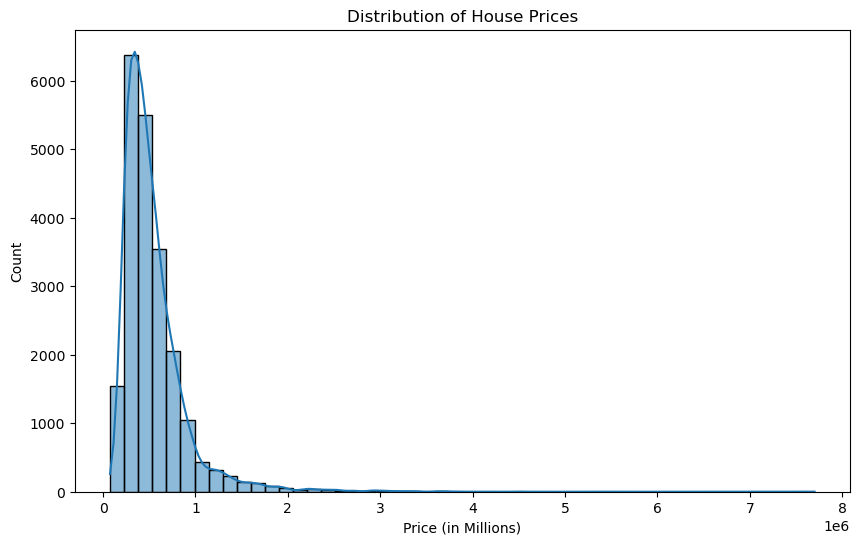

In [8]:
# Visualize the distribution of the target variable (price)
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], bins=50, kde=True)
plt.title('Distribution of House Prices')
plt.xlabel('Price (in Millions)')
plt.show()

## Correlation Analysis


--- Top Correlated Features with Price ---
sqft_living      0.702035
grade            0.667434
sqft_above       0.605567
sqft_living15    0.585379
bathrooms        0.525138
view             0.397293
sqft_basement    0.323816
bedrooms         0.308350
lat              0.307003
waterfront       0.266369
Name: price, dtype: float64


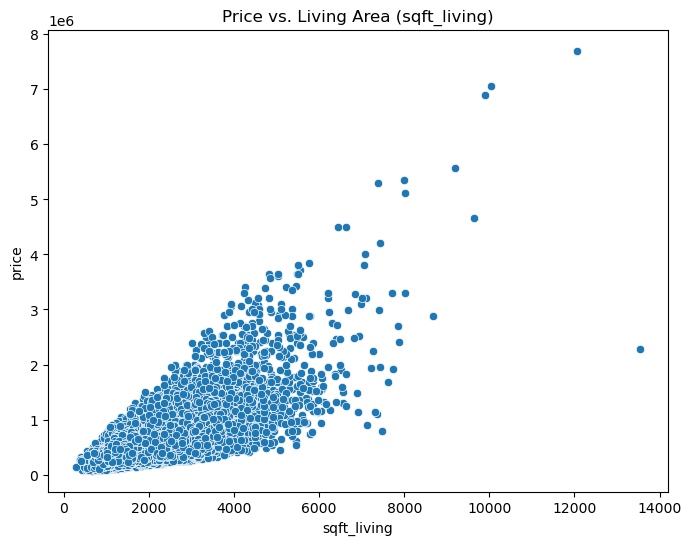

In [9]:
# Calculate correlation matrix and display the top features most correlated with 'price'
correlation_matrix = df.corr(numeric_only=True)
price_correlation = correlation_matrix['price'].sort_values(ascending=False).drop('price')

print("\n--- Top Correlated Features with Price ---")
print(price_correlation.head(10))

# Visualize the correlation between the top predictor (likely 'sqft_living') and 'price'
plt.figure(figsize=(8, 6))
sns.scatterplot(x='sqft_living', y='price', data=df)
plt.title('Price vs. Living Area (sqft_living)')
plt.show()

## Feature Engineering and Preprocessing

Price column successfully log-transformed.


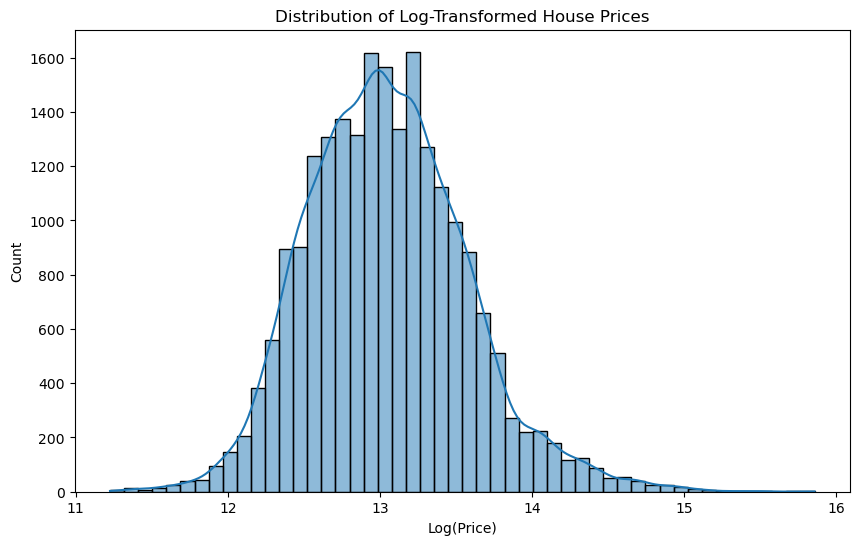

In [10]:
# Apply natural log transformation to the price column to reduce right-skewness
df['price_log'] = np.log(df['price'])

# We will use this new 'price_log' as our target variable (y) for training.

print("Price column successfully log-transformed.")

# Optional: Visualize the new log-transformed distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['price_log'], bins=50, kde=True)
plt.title('Distribution of Log-Transformed House Prices')
plt.xlabel('Log(Price)')
plt.show()

In [11]:
# Create a feature for the age of the house
# Note: Assuming the latest sale year (the max year in the dataset) is 2015. 
# We'll use 2015 for demonstration.
CURRENT_YEAR_FOR_AGE = 2015 
df['house_age'] = CURRENT_YEAR_FOR_AGE - df['yr_built']

# Create a feature for the house renovation status
# 1 if the house has been renovated (yr_renovated > 0), 0 otherwise
df['is_renovated'] = df['yr_renovated'].apply(lambda yr: 1 if yr > 0 else 0)

# Drop the original year columns as we have extracted the age
df.drop(['yr_built', 'yr_renovated'], axis=1, inplace=True)

print("New features ('house_age', 'is_renovated') successfully engineered.")

New features ('house_age', 'is_renovated') successfully engineered.


## Handling Categorical Features: One-Hot Encoding

In [12]:
# The zipcode column needs encoding
categorical_cols = ['zipcode']

# Apply One-Hot Encoding
# drop_first=True prevents multicollinearity (dummy variable trap)
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

print(f"\n Categorical features encoded. Total columns now: {df.shape[1]}")
print("Example of encoded columns:", [col for col in df.columns if col.startswith('zipcode_')][:5])


 Categorical features encoded. Total columns now: 90
Example of encoded columns: ['zipcode_98002', 'zipcode_98003', 'zipcode_98004', 'zipcode_98005', 'zipcode_98006']


## Model Selection & Data Splitting

In [13]:
from sklearn.model_selection import train_test_split

# Identify columns to exclude from the feature set (X)
# 'price_log' is the new target, and 'price' and 'date' are the original variables to drop.
features_to_drop = ['price', 'date'] 

# X contains all prepared features (including engineered and one-hot encoded columns)
# Drop the original 'price' and 'date' columns, and the new target 'price_log' from X.
X = df.drop(features_to_drop + ['price_log'], axis=1)

# y contains the log-transformed price, which our model will predict.
y = df['price_log']

# Verify the final number of features
print(f"Total features (X columns) selected: {X.shape[1]}")
print(f"Target variable (y) selected: price_log")

Total features (X columns) selected: 87
Target variable (y) selected: price_log


In [14]:
# Split the data: 80% for training and 20% for testing.
# random_state=42 ensures the data is split consistently every time for reproducibility.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTraining set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")


Training set size: 17290 samples
Testing set size: 4323 samples


## Model Training (Linear Regression)

In [15]:
from sklearn.linear_model import LinearRegression

# 1. Initialize the Linear Regression Model
# We use the standard Linear Regression model from scikit-learn
model = LinearRegression()

# 2. Train the Model
# The 'fit' method finds the optimal coefficients (beta values) based on the training data, 
# minimizing the Sum of Squared Errors.
model.fit(X_train, y_train)

print("Linear Regression Model successfully trained.")

# 3. Inspect the Coefficients (Optional but insightful)
print("\n--- Model Coefficients (Top 5) ---")
# Pair the feature names with their calculated coefficients
coefficients = pd.Series(model.coef_, index=X_train.columns)
# Display coefficients for the top 5 most positively correlated features
print(coefficients.sort_values(ascending=False).head(5))

Linear Regression Model successfully trained.

--- Model Coefficients (Top 5) ---
zipcode_98039    1.068382
zipcode_98004    0.946753
zipcode_98112    0.842803
zipcode_98109    0.773972
zipcode_98119    0.743788
dtype: float64


## Prediction and Evaluation

In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1. Make predictions on the test set (log-transformed)
y_pred_log = model.predict(X_test)

# 2. Inverse Transform Predictions (Bringing back to original price scale)
y_pred_original = np.exp(y_pred_log)

# Inverse transform the actual test values (y_test) for comparison
y_test_original = np.exp(y_test)

In [ ]:
## Evaluation Metrics Calculation

In [17]:
# Calculate R^2 Score (on log-transformed data is common for model fit)
r2 = r2_score(y_test, y_pred_log)

# Calculate MAE and RMSE (on original price scale for easy interpretation)
mae = mean_absolute_error(y_test_original, y_pred_original)
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))

print("\n--- Model Evaluation Results ---")
print(f"R-squared Score (on log scale): {r2:.4f}")
print(f"Mean Absolute Error (MAE): ${mae:,.2f}")
print(f"Root Mean Squared Error (RMSE): ${rmse:,.2f}")


--- Model Evaluation Results ---
R-squared Score (on log scale): 0.8779
Mean Absolute Error (MAE): $80,922.85
Root Mean Squared Error (RMSE): $222,087.18


In [ ]:
## Visualizing Predictions vs. Actuals

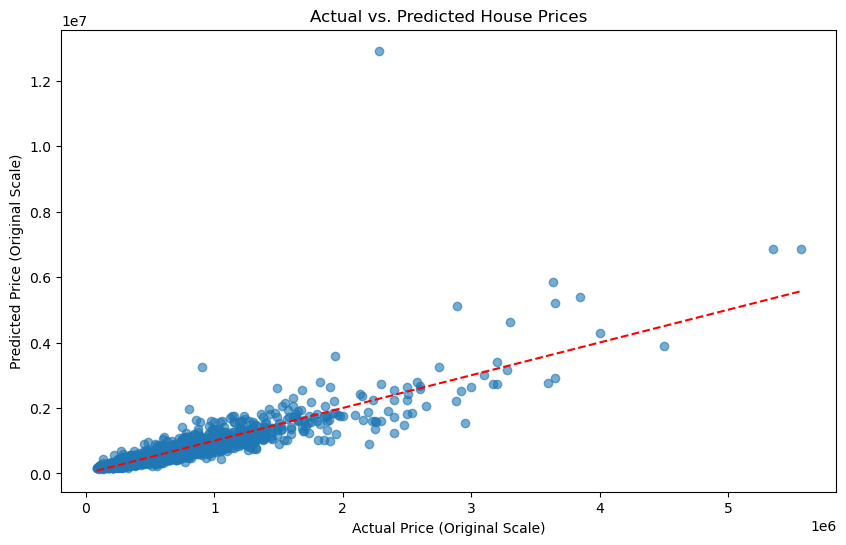

In [18]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test_original, y_pred_original, alpha=0.6)
# Plot the 45-degree line (Perfect Prediction Line)
plt.plot([y_test_original.min(), y_test_original.max()], 
         [y_test_original.min(), y_test_original.max()], 
         color='red', linestyle='--')
plt.xlabel("Actual Price (Original Scale)")
plt.ylabel("Predicted Price (Original Scale)")
plt.title("Actual vs. Predicted House Prices")
plt.show()

## Model Improvement using Ridge Regression

In [19]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

# 1. Define the parameters to search (alpha is the regularization strength)
# Alpha jitna bada hoga, regularization utna zyada hoga.
ridge_params = {'alpha': [0.1, 1.0, 10.0, 100.0]}

# 2. Initialize GridSearchCV
# GridSearchCV har alpha value par cross-validation karega aur best model dhundhega.
# 'neg_mean_squared_error' is used as the scoring metric for regression.
ridge_cv = GridSearchCV(
    estimator=Ridge(random_state=42), 
    param_grid=ridge_params, 
    scoring='neg_mean_squared_error', 
    cv=5 # 5-fold cross-validation
)

# 3. Fit (Train) the GridSearchCV model
ridge_cv.fit(X_train, y_train)

# 4. Get the Best Alpha and R^2 Score
best_alpha = ridge_cv.best_params_['alpha']
best_ridge_model = ridge_cv.best_estimator_

# 5. Evaluate the Best Ridge Model
ridge_pred_log = best_ridge_model.predict(X_test)
ridge_r2 = r2_score(y_test, ridge_pred_log)
ridge_mae = mean_absolute_error(np.exp(y_test), np.exp(ridge_pred_log))

print(f"\n--- Ridge Regression Results (Comparison) ---")
print(f"Optimal Alpha found: {best_alpha}")
print(f"Linear Regression R²: {0.8779:.4f}")
print(f"Ridge Regression R²: {ridge_r2:.4f}")
print(f"Ridge Regression MAE: ${ridge_mae:,.2f}")


--- Ridge Regression Results (Comparison) ---
Optimal Alpha found: 0.1
Linear Regression R²: 0.8779
Ridge Regression R²: 0.8778
Ridge Regression MAE: $80,921.03


In [ ]:
## Advance Regression (XGBoost Regressor)

In [20]:
##import
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, r2_score

In [21]:
## Model Training (XGBoost Regressor)

In [22]:
# Initialize the XGBoost Regressor model
# n_estimators=100 (number of boosting rounds/trees)
# random_state=42 for reproducibility
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror', 
    n_estimators=100, 
    learning_rate=0.1, 
    random_state=42, 
    n_jobs=-1
)

print("Training XGBoost Regressor...")
# Train the model on the log-transformed data
xgb_model.fit(X_train, y_train)

print(" XGBoost Regressor Model successfully trained.")

Training XGBoost Regressor...
 XGBoost Regressor Model successfully trained.


In [ ]:
## Prediction and Evaluation

In [23]:
# Predict on the test set (log-transformed)
xgb_pred_log = xgb_model.predict(X_test)

# Inverse Transform Predictions for comparison metrics
xgb_pred_original = np.exp(xgb_pred_log)
y_test_original = np.exp(y_test) # Already calculated in Step 6, but repeating for context

# Calculate Evaluation Metrics
xgb_r2 = r2_score(y_test, xgb_pred_log)
xgb_mae = mean_absolute_error(y_test_original, xgb_pred_original)

print("\n--- Advanced Model Evaluation Results ---")
print(f"XGBoost R-squared Score (on log scale): {xgb_r2:.4f}")
print(f"XGBoost Mean Absolute Error (MAE): ${xgb_mae:,.2f}")


--- Advanced Model Evaluation Results ---
XGBoost R-squared Score (on log scale): 0.9055
XGBoost Mean Absolute Error (MAE): $67,742.95
